### Creation et traitement des images 

In [18]:
import numpy as np
import cv2
import tensorflow as tf

def concat_images_resize_128(images, labels, n_mix=2):
    batch_size, h, w, c = images.shape
    final_h, final_w = 128, 128
    width_per_img = final_w // n_mix

    mixed_images = []
    mixed_labels = []

    for _ in range(batch_size):
        idxs = np.random.choice(batch_size, n_mix, replace=True)
        imgs_to_concat = []

        for i in idxs:
            # Redimensionner chaque image à (128, width_per_img)
            resized_img = cv2.resize(images[i], (width_per_img, final_h))
            imgs_to_concat.append(resized_img)

        # Concaténation horizontale des n_mix images
        concat_img = np.hstack(imgs_to_concat)

        # Moyenne des labels pour avoir un label multi-label
        mixed_label = np.max(labels[idxs], axis=0)

        mixed_images.append(concat_img)
        mixed_labels.append(mixed_label)

    return np.array(mixed_images), np.array(mixed_labels)

class MixConcatResizeGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, n_mix=2):
        self.generator = generator
        self.n_mix = n_mix

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, idx):
        images, labels = self.generator[idx]
        mixed_images, mixed_labels = concat_images_resize_128(images, labels, self.n_mix)
        return mixed_images, mixed_labels


### Ajout des images et mixer

In [19]:
#Lecture Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_size = (128, 128)
batch_size = 32

# Générateurs
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "data/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    "data/validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    "data/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Remplace train_gen par ce générateur mixup
train_gen_mixup = MixConcatResizeGenerator(train_gen, n_mix=2)
test_gen_mixup = MixConcatResizeGenerator(test_gen, n_mix=2)
val_gen_mixup = MixConcatResizeGenerator(val_gen, n_mix=2)
print(len(train_gen_mixup) * train_gen.batch_size)

Found 4897 images belonging to 36 classes.
Found 635 images belonging to 36 classes.
Found 557 images belonging to 36 classes.
4928


Affichage des images générés

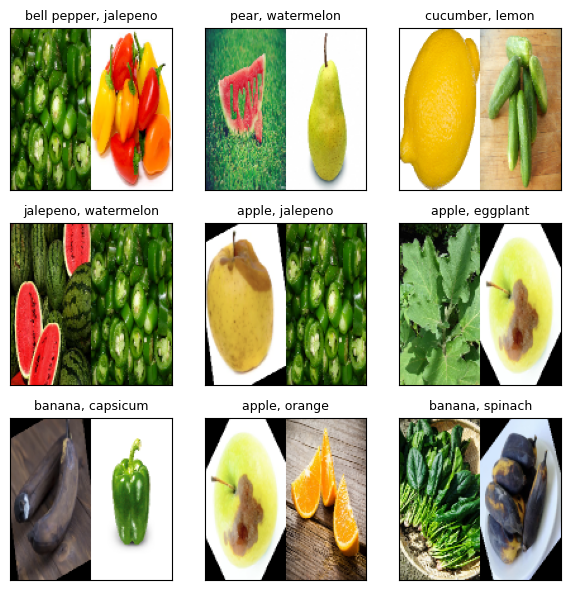

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Récupérer un batch du générateur mixup
images, labels = train_gen_mixup[0]  # premier batch (index 0)

# Nombre d’images à afficher (max 9)
n = min(9, images.shape[0])

# Classes
class_names = list(train_gen.class_indices.keys())

fig, axes = plt.subplots(3, 3, figsize=(6, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    img = images[i]
    
    # img est en float (0-1 ?), si besoin convertir en uint8 0-255 pour afficher correctement
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    
    ax.imshow(img)
    
    # Labels binaires, on affiche les noms où label = 1 (ou > 0.5)
    label_vec = labels[i]
    active_labels = [class_names[j] for j, val in enumerate(label_vec) if val > 0.5]
    
    ax.set_title(', '.join(active_labels), fontsize=9)

plt.tight_layout()
plt.show()


##### Autre Affichage

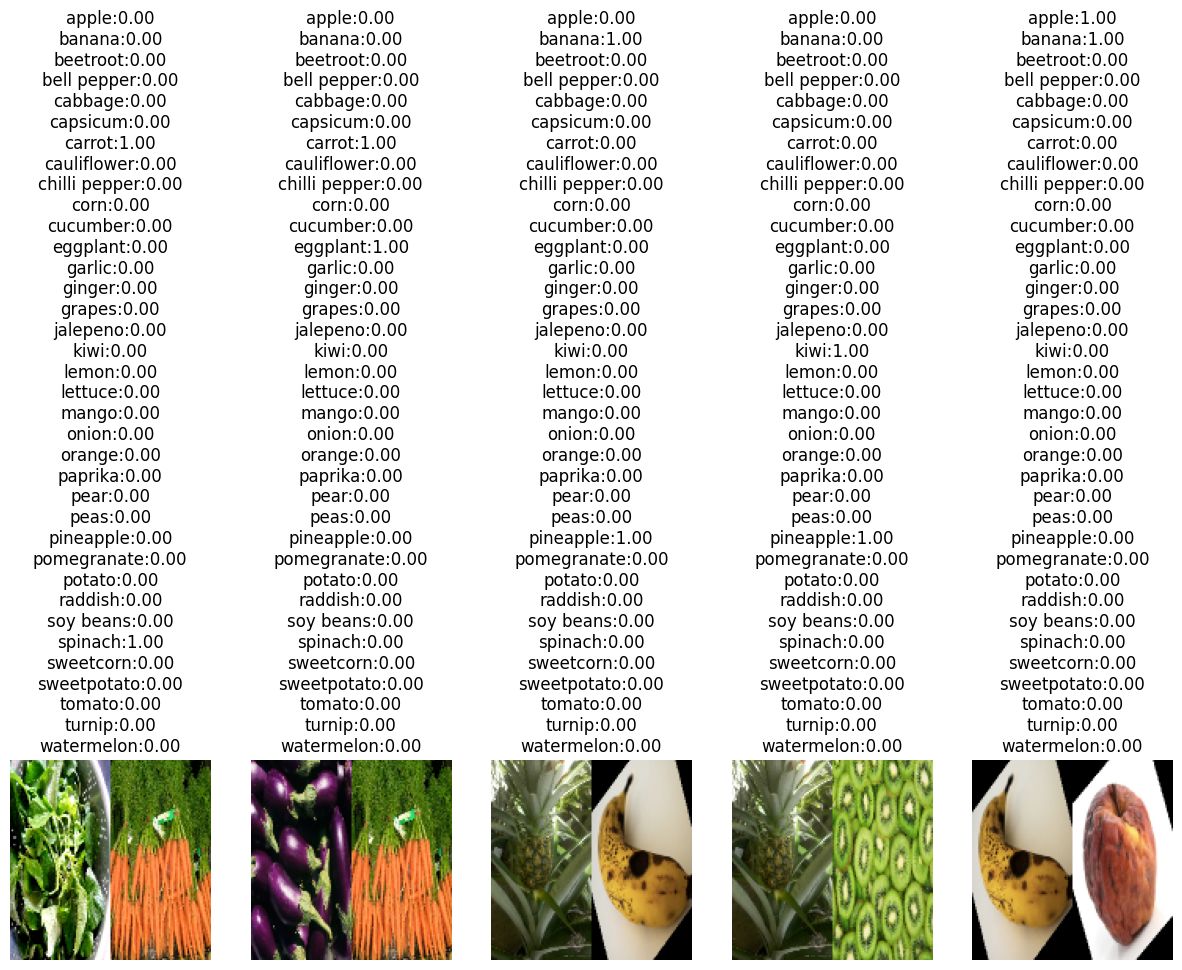

In [4]:
import matplotlib.pyplot as plt

def show_first_images(generator, class_indices):
    images, labels = generator[0]  # Prend le premier batch
    label_names = list(class_indices.keys())
    plt.figure(figsize=(15, 3))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i])
        # Affiche les pourcentages pour chaque classe
        label_percent = [f"{name}:{labels[i][j]:.2f}" for j, name in enumerate(label_names)]
        plt.title("\n".join(label_percent))
        plt.axis('off')
    plt.show()

# Utilisation :
show_first_images(train_gen_mixup, train_gen.class_indices)

### Modèle de base sans tuner 

In [5]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping

# model = Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Conv2D(256, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(2, 2),

#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),

#     # Multilabel output layer
#     Dense(train_gen.num_classes, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],learning_rate=0.001)
# model.summary()

# early_stop = EarlyStopping(
#     monitor='val_loss',      # Surveille la perte de validation
#     patience=3,              # Arrête après 3 epochs sans amélioration
#     restore_best_weights=True
# )


### Ajustement des hyperparamètres avec Keras.tuner

In [6]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fonction de construction du modèle
def build_model(hp):
    model = Sequential()

    # Bloc 1
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', [32, 64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(128, 128, 3)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc 2
    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', [64, 128, 256]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Bloc 3
    model.add(Conv2D(
        filters=hp.Choice('conv3_filters', [128, 256, 512]),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense
    model.add(Dense(
        units=hp.Choice('dense_units', [128, 256, 512]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)))

    model.add(Dense(train_gen.num_classes, activation='sigmoid'))  # Multilabel output

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',  # Pour multilabel
        metrics=['accuracy']
    )

    return model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='fruit_multilabel'
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Recherche des meilleurs hyperparamètres
tuner.search(train_gen_mixup, validation_data=val_gen_mixup, epochs=20, callbacks=[early_stop])

# Meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hp.values)


Reloading Tuner from kt_dir\fruit_multilabel\tuner0.json

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
128               |64                |conv1_filters
256               |256               |conv2_filters
256               |128               |conv3_filters
128               |512               |dense_units
0.3               |0.5               |dropout
0.001             |0.001             |learning_rate
10                |10                |tuner/epochs
4                 |4                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |2                 |tuner/round
0014              |0012              |tuner/trial_id




c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arg

Epoch 5/10
  4/154 ━━━━━━━━━━━━━━━━━━━━ 5:26 2s/step - accuracy: 0.3197 - loss: 0.3229

c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  8/154 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.3282 - loss: 0.3090

KeyboardInterrupt: 

In [21]:
# Meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters(num_trials=2)[0]
print("Best hyperparameters:")
print(best_hp.values)

Best hyperparameters:
{'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 128, 'dense_units': 512, 'dropout': 0.5, 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}


In [16]:
tuner.results_summary()

Results summary
Results in kt_dir\fruit_multilabel
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0016 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 256
conv3_filters: 128
dense_units: 512
dropout: 0.5
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.4346456825733185

Trial 0000 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 256
conv3_filters: 128
dense_units: 512
dropout: 0.5
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.30708661675453186

Trial 0012 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 256
conv3_filters: 128
dense_units: 512
dropout: 0.5
learning_rate: 0.001
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0000
Score: 0.29291337728500366

Trial 0004 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 128
conv3_filters: 128
dense_units: 128


### Entrainements 

In [22]:
model = tuner.hypermodel.build(best_hp)
history = model.fit(train_gen_mixup, 
          validation_data=val_gen_mixup, 
          epochs=20, 
          callbacks=[early_stop]
          )

c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
  5/154 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.1036 - loss: 1.0944

c:\Users\paulf\Documents\UTT\SN02\Crunch-2025\.venv\Lib\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.2113 - loss: 0.5950 - val_accuracy: 0.0252 - val_loss: 0.4116
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3348 - loss: 0.2317 - val_accuracy: 0.1386 - val_loss: 0.2015
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3847 - loss: 0.2122 - val_accuracy: 0.2567 - val_loss: 0.2070
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3786 - loss: 0.2041 - val_accuracy: 0.4016 - val_loss: 0.1627
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3820 - loss: 0.1874 - val_accuracy: 0.4142 - val_loss: 0.1682
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.3980 - loss: 0.1863 - val_accuracy: 0.4488 - val_loss: 0.1472
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.4287 - loss: 0.1753 - val_accuracy: 0.4315 - val_loss: 0.1468
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - accuracy: 0.4121 - loss: 0.1741 - val_accuracy: 0.467

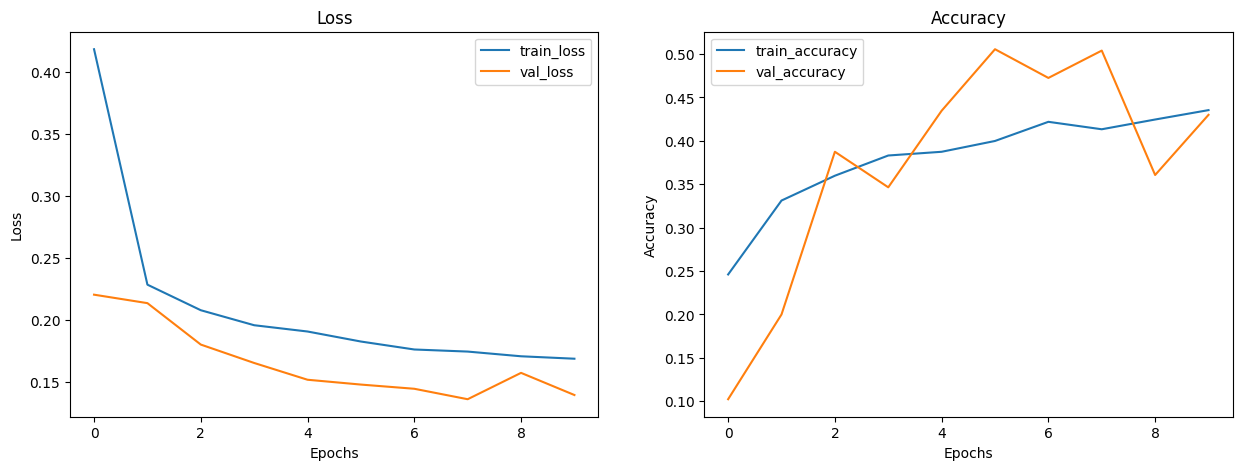

In [ ]:
import pandas as pd
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'], label='train_loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss') 
axes[0].legend()
axes[1].plot(history.history['accuracy'], label='train_accuracy')
axes[1].plot(history.history['val_accuracy'], label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


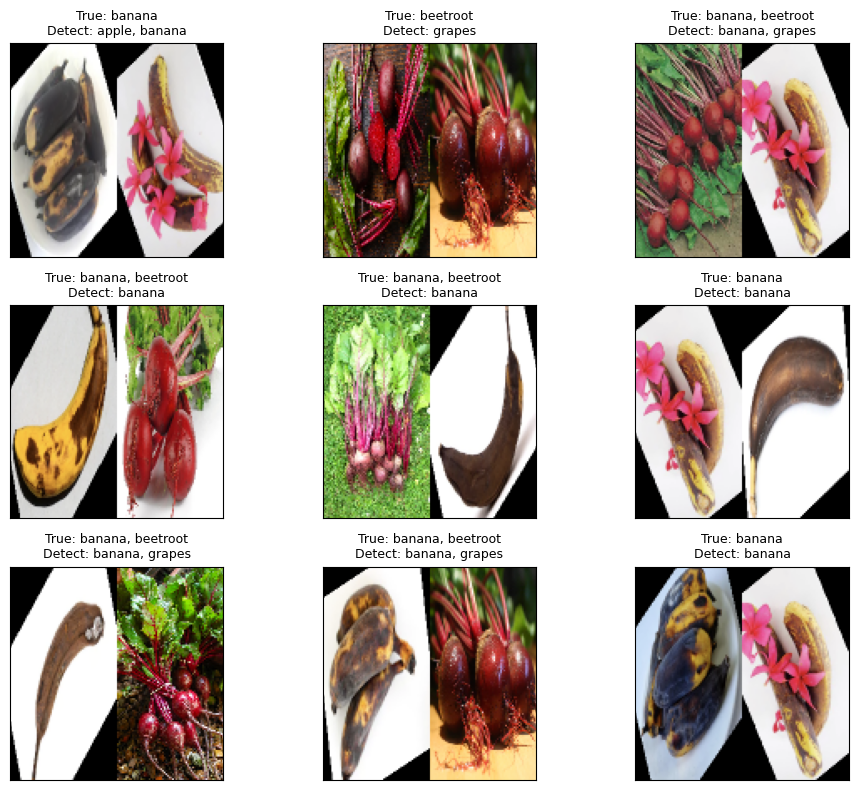

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Récupère un batch du générateur de test (par exemple test_gen_mixup)
images, true_labels = test_gen_mixup[4]  # ou test_gen[0] si pas de mixup

# Prédis les classes
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.2).astype(int)  # seuillage pour obtenir 0 ou 1

# Noms des classes dans le bon ordre
class_names = list(test_gen.class_indices.keys())

# Nombre d’images à afficher
n = min(9, images.shape[0])

fig, axes = plt.subplots(3, 3, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    img = images[i]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    ax.imshow(img)

    # Vraies classes
    true_classes = [class_names[j] for j, val in enumerate(true_labels[i]) if val == 1]
    # Prédictions
    pred_classes = [class_names[j] for j, val in enumerate(pred_labels[i]) if val > 0.4]

    ax.set_title(f"True: {', '.join(true_classes)}\nDetect: {', '.join(pred_classes)}", fontsize=9)

plt.tight_layout()
plt.show()
